In [371]:
# standard python utilities
import os
from os.path import dirname, basename
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import flopy

In [372]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel/'
gwfm_dir

'C:\\Users\\ajcalder/Box/research_cosumnes/GWFlowModel/'

In [373]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/streamflow/'
base_model_ws = loadpth+'historical_streamflow/'
model_ws = loadpth+'setback_streamflow/'

# Load historical model
Load historical model and adjust needed pacakges to account for levee setback

In [471]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)
m = flopy.modflow.Modflow.load('MF.nam',  model_ws=base_model_ws, version='mfnwt')
# change model_ws
m.change_model_ws(model_ws)


changing model workspace...
   F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/streamflow/setback_streamflow/


In [454]:
# remove external file connections of the pcgno and tab
# m.remove_external('DATA')

In [458]:
m.get_ext_dict_attr()

(None, None)

###### 

In [455]:
# m.write_name_file()

In [375]:
os.makedirs(m.model_ws+'/input_data',exist_ok=True)

In [376]:
nlay = m.dis.nlay
nrow = m.dis.nrow
ncol = m.dis.ncol
nper = m.dis.nper
dem_data = m.dis.top.array

## Load TPROGs for SFR/LAK input

In [377]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

In [378]:
tprogs_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# sys.path
import tprogs_cleaning as tc

In [379]:
from importlib import reload
# importlib.reload
reload(tc)

<module 'tprogs_cleaning' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/tprogs_utilities\\tprogs_cleaning.py'>

In [380]:
# check one or zero based but min:1, 90:mean, max:34
t=0
tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, dem_data)
K, Sy, Ss= tc.int_to_param(masked_tprogs, params)

# save tprogs facies array as input data for use during calibration
tprogs_dim = masked_tprogs.shape
np.savetxt(model_ws+'/input_data/tprogs_facies_array.tsv', np.reshape(masked_tprogs, (tprogs_dim[0]*nrow,ncol)), delimiter='\t')
# masked_tprogs = np.reshape(np.loadtxt(model_ws+'/input_data/tprogs_facies_array.tsv', delimiter='\t'), (320,100,230))


## Define setback scenario here

In [381]:
scenario='design' # 600 meter setback

In [382]:
sfr_dir = gwfm_dir+'SFR_data/'
lak_dir = gwfm_dir +'LAK_data/'
proj_dir = gwfm_dir+'Levee_setback/'
dem_dir = gwfm_dir+ 'DEM_data/'

In [383]:
setback_max = gpd.read_file(proj_dir+'blodgett_levee_setback_max_extent/blodgett_levee_setback_max_extent.shp')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [384]:
# grid_sfr.to_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')

# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
# print(gwfm_dir)

# Find Michigan Bar location
# mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
# mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', op = 'intersects')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Create Lake Package
Update to use buffered river instead of pre-made shapefile

In [385]:
# buffer by 600 m to reach about halfway out from Deer creek on north and to edge of Laguna del Sol on south
sfr_buf = grid_sfr.copy()
sfr_buf.geometry = sfr_buf.geometry.buffer(600)
# limit setback with maximum extents defined by Folsom South Canal, Laguna del Sol housing, Teichert vineyard and Deer Creek 
sfr_setback = gpd.overlay(sfr_buf, setback_max)


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute

In [510]:
# create joined sfr setback cells for cleaner overlay
sfr_setback_poly = gpd.GeoDataFrame([0])
sfr_setback_poly.geometry = [sfr_setback.geometry.unary_union]
sfr_setback_poly.crs=sfr_setback.crs
# overlay model grid with setback extent to find lake cells
lak_grid_clip = gpd.overlay(grid_p, sfr_setback_poly)

# find sfr nodes within current lake polygon
sfr_lak_nodes = lak_grid_clip.set_index('node').filter(sfr_setback.node.astype(int),axis=0)
# remove sfr cells from lak
lak_grid_clip = lak_grid_clip.set_index('node').drop(sfr_lak_nodes.index)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:304: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for this_elem, other_elem in zip(left, right)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:304: DeprecationWarning: An exception was ignored wh

### Options for representing the floodplains
1. The SFR package and LAKE package overlap one another and flow is specified in and out of the lake at the upstream and downstream ends.
2. The SFR package is removed where the LAKE package exists so SFR feeds into the upstream end and then is re-created at the downstream end. In this scenario all flow is routed into the floodplain (LAK) and outflow would be stage dependent with no high flow channel passing between, but no diversion criteria are needed.
3. The floodplain is split into two parts (two LAK tab files). A diversion threshold is set based on the expected upstream inflow elevation and corresponding flow (elevation low near the channel in the field - assumes levee is cut  to field level and removed). And a return flow threshold is staged based in the lak package. Or just assume the threshold is set the same on both sides so flooding is equal, but adapt later.
4. Same as option 3, but the SFR XS is redesigned assuming the levee cut fill goes into the stream bottom reducing the threshold for overflow. Test this scenario if insufficient floodplain inundation occurs.

Option 1 should not be used because it is doubling recharge in the channel. Option 2 would most likely overemphasize recharge in the channel because retention time would increase by being limited by simple stage outflow at bottom. Option 3 is best for now.

In [387]:
def gdf_2_lims(gdf,ax):
    xmin, ymin = gdf.geometry.bounds.loc[:,['minx','miny']].min()
    xmax, ymax = gdf.geometry.bounds.loc[:,['maxx','maxy']].max()
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)

<AxesSubplot:>

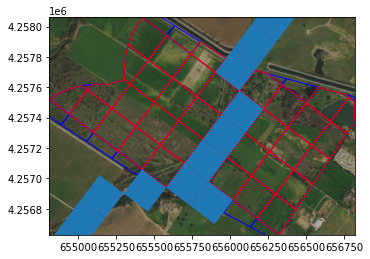

In [513]:
fig,ax=plt.subplots()
lak_grid_clip.plot(ax=ax, color='None',edgecolor='blue')
# filter for cells that have more than half left after cropping
lak_grid = lak_grid_clip[lak_grid_clip.geometry.area> 200*200*0.5]
lak_grid.plot(ax=ax, color='None',edgecolor='red')
ctx.add_basemap(ax=ax,crs='epsg:26910', source=ctx.providers.Esri.WorldImagery,attribution=False)
gdf_2_lims(lak_grid,ax)
grid_sfr.plot(ax=ax)

In [521]:

# Set empty array of zeros for nonlake cells
lakarr = np.zeros((nlay, nrow,ncol))
lak_rows = (lak_grid_clip.row.values-1).astype(int)
lak_cols = (lak_grid_clip.column.values-1).astype(int)
# Each lake is given a different integer, and needs to be specified depending on the layer
lakarr[0,lak_rows,lak_cols] = 1

# look at shallower TPROGs data, should be near conductivity of unsat zone
bdlknc = np.zeros(( nrow,ncol))

tprogs_info = [80, -80, 320]

lkbd_thick = 4
top = m.dis.top.array
bot_str_arr = m.dis.top.array- lkbd_thick
# get_tprogs_for_elev(K, m_c.dis.top.array, m_c.dis.top.array- np.linspace(1,4,m_c.dis.ncol), rows = sfr_rows, cols = sfr_cols)
lkbd_tprogs = tc.get_tprogs_for_elev(K, top, bot_str_arr, tprogs_info,rows = lak_rows, cols = lak_cols)
lk_K = gmean(lkbd_tprogs,axis=0)/100 # divide by 100 to ease convergence, but variability is still there
#     # set blodgett dam Ksat same as stream Ksat at same location, leakance is K/lakebed thickness
#     lkbd_thick = sfr.reach_data.strthick[XSg.loc[XSg.Site==16.5].reach]
bdlknc[lak_rows,lak_cols] = lk_K/lkbd_thick
    

In [522]:
# import json
import rasterio
from rasterio.mask import mask

dem_1m = dem_dir+'/HECRAS_dem/Terrain.Cos.reprojected.tif'
dem_10m = dem_dir+'/USGS_ten_meter_dem/modeldomain_10m_transformed.tif'

geoms = [lak_grid.geometry.unary_union]

def clip_raster(raster_name, geom):
    '''load the raster, mask it by the polygon, crop it and save it'''
    with rasterio.open(raster_name) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()

        # save the resulting raster
        out_meta.update({"driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform})
    with rasterio.open(proj_dir + "/lak_clipped_"+ basename(raster_name), "w", **out_meta) as dest:
        dest.write(out_image)
#     return(out_image[0,:,:], out_meta)

clip_raster(dem_1m,geoms)
clip_raster(dem_10m,geoms)

In [523]:
dem_1m_clip = proj_dir + "/lak_clipped_"+ basename(dem_1m)
dem_10m_clip = proj_dir + "/lak_clipped_"+ basename(dem_10m)

In [524]:
def calc_lak_vol(raster_file, z_units):
    ''' takes a raster input and calculates the 151 steps of elevation, volume and area needed for
    the lake package in MODFLOW'''
    fact = 0.3048 if z_units=='ft' else 1
        
    lakeRst = rasterio.open(raster_file)
    lakeBottom = lakeRst.read(1)
    noDataValue = np.copy(lakeBottom[0,0])
    #replace value for np.nan
    lakeBottom[lakeBottom==noDataValue]= np.nan
    # the stage for the stream section just after the dam is 23.04 m thus the bottom of the lake must be set 10 ft below that
#     lakeBottom = lakeBottom - 10
    lakeBottom *= fact # convert from ft to meters if dem is in feet

    # get raster minimum and maximum 
    minElev = np.nanmin(lakeBottom)
    maxElev = np.nanmax(lakeBottom)
    print('Min bottom elevation %.2f m., max bottom elevation %.2f m.'%(minElev,maxElev))

    # steps for calculation
    nSteps = 151
    # lake bottom elevation intervals
    elevSteps = np.round(np.linspace(minElev,maxElev,nSteps),2)
    print('tempDem',(elevSteps[10]-lakeBottom[lakeBottom<elevSteps[10]]).shape, 'dem shape',lakeBottom.shape)
    # definition of volume function
    def calculateVol_A(elevStep,elevDem,lakeRst):
        ''' calculates volume for an elevation step and cell area'''
        tempDem = elevStep - elevDem[elevDem<elevStep]
        tempArea = len(tempDem)*lakeRst.res[0]*lakeRst.res[1]
        tempVol = tempDem.sum()*lakeRst.res[0]*lakeRst.res[1]
        return(tempVol, tempArea)
    # calculate volumes, areas for each elevation
    volArray = [0]
    saArray = [0]
    for elev in elevSteps[1:]:
        tempVol,tempArea = calculateVol_A(elev,lakeBottom,lakeRst)
        volArray.append(tempVol)
        saArray.append(tempArea)

#     print("Lake bottom elevations %s"%elevSteps)
#     volArrayMCM = [round(i/1000000,2) for i in volArray]
#     print("Lake volume in million of cubic meters %s"%volArrayMCM)
    plt.plot(elevSteps,volArray)
    plt.xlabel('elevation (m)')
    plt.ylabel('volume ($m^3$)')
    return(elevSteps, volArray, saArray)

Min bottom elevation 21.74 m., max bottom elevation 32.50 m.
tempDem (364,) dem shape (1504, 2112)
Min bottom elevation 24.54 m., max bottom elevation 33.62 m.
tempDem (18,) dem shape (156, 219)


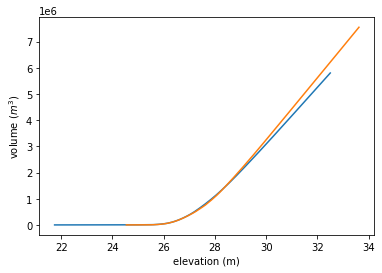

In [525]:
elev_1m, vol_1m, SA_1m= calc_lak_vol(dem_1m_clip, z_units='ft')

elev_10m, vol_10m, SA_10m = calc_lak_vol(dem_10m_clip, z_units='m')

In [526]:
if (scenario == 'design'):
    # Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
    #  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
    # A separate file is required for each lake. 
    stages = minElev+0.1
    # (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
    # so double array is necessary
    stage_range = [[minElev, maxElev]]

    # lake stage (elevation), volume, and area (3 numbers per line)
    lak_depth = elev_1m - elev_1m[0]
    bathtxt = np.column_stack((elev_1m, vol_1m, SA_1m))
#     lak_depth = elev_10m - elev_10m[0]
#     bathtxt = np.column_stack((elev_10m, vol_10m, SA_10m))
    np.savetxt(m.model_ws+'/MF.txt', bathtxt, delimiter = '\t')

    ## Need to specify flux data
    # Dict of lists keyed by stress period. The list for each stress period is a list of lists,
    # with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
    flux_data = {0:{0:[0,0,0,0]}}
    # filler value for bdlknc until soil map data is loaded by uzf
    lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
                                   stage_range=stage_range, flux_data = flux_data,tabdata= True, 
                                   tab_files='MF.txt', tab_units=[57],ipakcb=55)

    # the lak package doesn't specify the tab file unit number when the files are written
    # example:      110.0     100.0     170.0   22   Item 3:  STAGES,SSMN,SSMX,IUNITLAKTAB
    lak.options = ['TABLEINPUT']

    # need to reset tabdata as True before writing output for LAK
    lak.tabdata = True

In [397]:
# m.get_package_list()
# m.remove_external('MF.txt')

In [527]:
# m.remove_package('LAK')
# if m.get_name_file_entries().__contains__('.txt'):
#     print('has lake txt file')

flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'txt',unitnumber = 57)


Outside Package class

## Gage Package for Lake

In [533]:
if  (scenario == 'design'):
    # numgage is total number of gages
    # gage_data (list, or array), includes 2 to 3 entries (LAKE UNIT (OUTTYPE)) for each LAK entry
    #  4 entries (GAGESEG< GAGERCH, UNIT, OUTTYPE) for each SFR package entry

    lak_gage_data = [[-1, -37, 1]]
    lak_file = 'MF.lak.gage'
    lak_file_out = 'MF.lak.gage.out'
    gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=lak_gage_data,file =[lak_file_out], filenames =[lak_file])


# Update BAS6 package

In [534]:
# set ibound cell to zero where lake is
ibound = m.bas6.ibound.array
ibound[lakarr==1]=0
m.bas6.ibound = ibound

m.bas6.write_file()

In [535]:
#  NO_FAILED_CONVERGENCE_STOP # add to options of bas6

'FREE STOPERROR 0.009999999776482582'

In [538]:
# flopy.utils.OptionBlock('FREE STOPERROR 0.01  NO_FAILED_CONVERGENCE_STOP', package='bas6', block=False)
# flopy.utils.OptionBlock(m.bas6.options, package='bas6', block=False)

# Update SFR Package
Reach data should not change between scenarios, only the segment data should be updated. The two cross-sections that are added should keep the same cross-section as the base scenario so the only change is the diversion of flow to the floodplain and return flow.

Added XS locs 16.5 and 17.5 for upstream and downstream end of levee setback floodplain connection, XS 17 is in the middle of the floodplain. Can assume the same XS17 for 16.5 and 17.5 for now.

In [401]:
# sfr = m.sfr

In [402]:
# XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs/8pointXS_locs.shp')
# new shapefile with an extra point for blodgett dam as site 16.5
XSlocs = gpd.read_file(gwfm_dir+'/Levee_setback/XS8pt_locs_setback/XS8pt_locs_setback.shp')
XSlocs.crs = 32610

XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", op= "contains", lsuffix = 'sfr',rsuffix = 'xs')
# print(len(XSg))

# # Append the grid_breach location to the list of cross sections to split the segment
# XSg = XSg.append(grid_breach).sort_values('reach')
# # Copy the XS site name from the previous last site to the breach site to keep same XS
# XSg.Site.iloc[-1] = XSg.Site.iloc[-2]
# len(XSg), len(XS8pt.loc[0,:])/2

if scenario == 'none':
    # if no blodgett dam scenario then remove the extra cross section
    XSg = XSg.loc[(XSg.Site!=16.5)]
    XSg = XSg.loc[(XSg.Site!=17.5)]
elif scenario == 'design':
    print('keep XS')
    # may or may not want to remove the segment before
#     XSg = XSg.loc[(XSg.Site!=16.2)]

# if the scneario is the restructured or designed dam then no change in the segments is necessary
# sort by site to make sure any XS added are properly included
XSg = XSg.sort_values('Site')
# print(len(XSg))
XSg['iseg'] = np.arange(2,len(XSg)+2) # add the segment that corresponds to each cross section

keep XS


In [403]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')


if scenario =='design':
    # XS 16.5/17.5 keep the same XS as 17
    XS17_col = np.where(XS8pt.columns=='17')[0][0]
    XS_16_5 = XS8pt.iloc[:,XS17_col:XS17_col+2].rename({'17':'16.5', '15.6':'15.55'},axis=1)
    XS_17_5 = XS8pt.iloc[:,XS17_col:XS17_col+2].rename({'17':'17.5', '15.6':'15.65'},axis=1)

# if scenario == 'design':
#     # designed scenario flow through dam only
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/02_designed_XS.csv', skiprows=1)

# if there is a scneario then need to add the new XS
if scenario != 'none':
    XS8pt = pd.concat([XS8pt,XS_16_5,XS_17_5],axis=1)
   

In [539]:
# There is one reach for each cell that a river crosses
NSTRM = -len(grid_sfr)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = 1 + len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 4
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 3


sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [540]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

## Rerun reach data 
Have to rerun the reach data even though the only piece that changes is NSS which impact section numbering

In [413]:
xs_sfr = grid_sfr.set_index('reach')
# set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
xs_sfr['iseg'] = 1
# add a column reach_new that will be changed iteratively as the segment number is changed
xs_sfr['reach_new'] = xs_sfr.index
# xs_sfr

In [414]:
## Given the reach number of each XS, the 718 reaches will be broken down into each segment
## create a new reach column based on XS reach number and 

# segcount = 2
for i in np.arange(0,len(XSg)):
    temp_reach = XSg.reach.values[i]
    rchnum = xs_sfr.index[-1] - temp_reach+1
    xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
#     xs_sfr.iseg.loc[temp_reach:] = segcount
    xs_sfr.iseg.loc[temp_reach:] = XSg.iseg.values[i]
#     segcount +=1
    
# for simple 1 XS model
# temp_reach = XSg.reach
# rchnum = xs_sfr.index[-1] - temp_reach+1
# xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
# xs_sfr.iseg.loc[temp_reach:] = segcount
# segcount +=1

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [415]:
xs_sfr.reach_new = xs_sfr.reach_new.astype(int)


In [418]:
botm = m.dis.botm.array

In [419]:
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
sfr_lay = np.zeros(len(grid_sfr))

for i in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[i, (grid_sfr.row.values-1).astype(int), (grid_sfr.column.values-1).astype(int)]
    for j in np.arange(0,len(grid_sfr)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[j] < (grid_sfr.z.values-1)[j]:
            sfr_lay[j] = i -1
        


In [421]:
uzf_path = gwfm_dir+'UZF_data'
soilKs_array = np.loadtxt(uzf_path+'/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(uzf_path+'/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(uzf_path+'/final_soileps.tsv', delimiter = '\t')
soildepth_array = np.loadtxt(uzf_path+'/final_soildepth.tsv', delimiter = '\t')



In [541]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr_rows = (grid_sfr.row.values-1).astype(int)
sfr_cols = (grid_sfr.column.values-1).astype(int)

sfr.reach_data.node = grid_sfr.index
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = sfr_rows
sfr.reach_data.j = sfr_cols
sfr.reach_data.iseg = xs_sfr.iseg
sfr.reach_data.ireach = xs_sfr.reach_new
sfr.reach_data.rchlen = xs_sfr.length_m.values
sfr.reach_data.strtop = grid_sfr.z.values-1
sfr.reach_data.slope = grid_sfr.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = soildepth_array[sfr.reach_data.i, sfr.reach_data.j]

# UZF parameters
sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]/100
sfr.reach_data.thti = sfr.reach_data.thts
sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.uch = m.lpf.vka.array[0,sfr.reach_data.i, sfr.reach_data.j].data


In [425]:
grid_sfr['dist_m'] = grid_sfr.length_m.cumsum()
grid_sfr.dist_m -= grid_sfr.dist_m.iloc[0]

### Update Strmbd K

In [426]:
topbotm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
topbotm[0,:,:] = m.dis.top.array
topbotm[1:,:,:] = m.dis.botm.array

Text(0.5, 0, 'Reach')

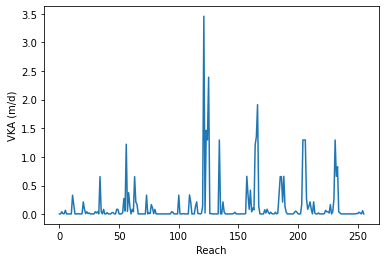

In [427]:
strbd_thick = 4
top = m.dis.top.array
bot_str_arr = m.dis.top.array- strbd_thick
# get_tprogs_for_elev(K, m_c.dis.top.array, m_c.dis.top.array- np.linspace(1,4,m_c.dis.ncol), rows = sfr_rows, cols = sfr_cols)
strbd_tprogs = tc.get_tprogs_for_elev(K, top, bot_str_arr, tprogs_info,rows = sfr_rows, cols = sfr_cols)
sfr_K = gmean(strbd_tprogs,axis=0)/100 # divide by 100 to ease convergence, but variability is still there
plt.plot(sfr_K)
plt.ylabel('VKA (m/d)')
plt.xlabel('Reach')
# temp fix to get convergence
# sfr_K = 0.01

In [542]:
# set stream hydraulic conductivity based on soil maps
# sfr.reach_data.strhc1 = soilKs_array[sfr.reach_data.i, sfr.reach_data.j]*scalingfactors.RIV
# set hydraulic conductivity smaller than aquifer hydraulic conductivity to limit interaction
# and ease the numerical stress
sfr.reach_data.strhc1 = sfr_K

# calibration of the whole river now by scaling conductivity
m.sfr.reach_data.strhc1 = m.sfr.reach_data.strhc1
# next step is to break river up into reaches based on the grain size analysis or perhaps just by stream segment

## Update segment numbering

In [429]:
# New segment numbers 16.5 = 17, 17.0=18, 17.5 = 19, and 16.5/17.5 use XS8pt 17

if (scenario=='design'):
    # copy segment 17 to use for 16.5 and 17.5
    pre_seg = XSg.loc[XSg.Site==16.5,'iseg'].iloc[0]
    post_seg = XSg.loc[XSg.Site==17.5,'iseg'].iloc[0]
# print(pre_seg,side_seg,post_seg)

In [430]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


### Determining floodplain inundation stage/flow
Manual analysis in QGIS by picking points out of the exported HEC-rAS dem on the far side of the levee (field sides).  
Field elevation low after levee on each side is 92.4 ft for LdS and 88.6 ft for the north side. say flow onto fields begins
 at 90 ft, river channel bottom is 78 ft in DEM (with water), so say 12ft stage is needed to flood


In [556]:
XSg.loc[XSg.Site==17]

,node,row,column,index_righ,z,easting,northing,slope,Point_orde,length_m,reach,geometry,index_xs,Distance_m,Elevation,Depth (m),Water surf,dist_diff_,Site,iseg
98,12110,53.0,150.0,2498.0,23.040936,655993.085445,4.257253e+06,0.0003,2498.0,210,99,"POLYGON ((655818.792 4257258.798, 655939.434 4...",15,15600.0,20.108,0.375,20.483,40.0,17.0,16


In [562]:
XSg17
k = XSg.loc[XSg.Site==17].Site.values[0]
pos = int(XS8pt.columns.get_loc(k))
XCPT = XS8pt.iloc[:,pos].values
ZCPT = XS8pt.iloc[:,pos+1].values

In [618]:
in_x = np.copy(XCPT)
in_z = np.copy(ZCPT)
def refine_XS(in_x, in_z, x_scale):
    ''' take input x and z cross-section data and downscale so there are
    more x points for numerical mannings equation'''
    out_x = np.linspace(in_x.min(), in_x.max(), (len(in_x)+1)*x_scale)
    out_z = np.zeros(len(out_x))
    in_slope = np.diff(in_z)/np.diff(in_x)
    for n,x in enumerate(out_x[:-1]):
        x = np.where(x>=in_x)[0].max()
        out_z[n] = in_z[x]+in_slope[x]*(out_x[n]-in_x[x])
    out_z[-1] = in_z[-1]
    return(out_x, out_z)

In [620]:
out_x, out_z = refine_XS(XCPT,ZCPT,10)


In [644]:
def mannings(dpth, xs_elevs, xs_dists, n, S):
    ''' requires fine resolution x to properly assume triangular area is
    negligible compared to rectanglular area above'''
    x_widths = np.diff(xs_dists) # distance between XS x locs
    centr_elevs = (xs_elevs[1:]+xs_elevs[:-1])/2 # avg elevation at centerpoint of segment
    
    wse = xs_elevs.min()+dpth
    xs_wet_dpth = wse - centr_elevs
    xs_wet_dpth[xs_wet_dpth < 0] = 0
    # multiply by 10m to get area and sum for area
    A = (xs_wet_dpth*x_widths).sum() 
    # calculate wetted perimeter
    x_wet = xs_elevs[wse - xs_elevs > 0]
    z_wet = xs_dists[wse - xs_elevs > 0 ]
    
    Wp = np.sum(np.sqrt(np.diff(x_wet)**2 + np.diff(z_wet)**2))
    print('wse %.2f'%wse,', A: %.2f'%A, ', Wp: %.2f'%Wp)
    Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
    return(Q_calc)

In [650]:
mannings(5*0.3048, out_z,out_x,XSg.loc[XSg.Site==17].slope.values[0],0.048)
# the values seem way to large to be realistic streamflows for the Cosumnes
# for now I'm putting a filler value of 2,000 cfs as the floodplain inundation level
# 2-3,000 cfs is when we historically saw floodplain inudnation
divert_flow = 2000 # flow diversion at 2000 cfs

wse 1.53 , A: 15.22 , Wp: 23.72


714311082.8111699

In [688]:
sfr_seg = sfr.get_empty_segment_data(nsegments=NSS)
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,len(XSg)+2)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion
# correct outseg and iupseg to account for Blodgett Dam scenario
if scenario =='design':
    sfr_seg.outseg[sfr_seg.nseg==pre_seg]=-1 # segment before dam flows to lake
    sfr_seg.iupseg[sfr_seg.nseg==post_seg]=-1 # lake outflow is diverted to segment after dam
    # 2-3,000 cfs is when we historically saw floodplain inudnation
    # to simplify, the channel takes all flow from 0 to 2,000 cfs above which it goes to the floodplain
    # iprior = 0 flow will be diverted from 0 up to FLOW, iprior=-3 any flows above the flow specified will be diverted
    sfr_seg.iupseg[sfr_seg.nseg==pre_seg+1] = pre_seg
    sfr_seg.iprior[sfr_seg.nseg==pre_seg+1] = 0
    sfr_seg.flow[sfr_seg.nseg==pre_seg+1] = divert_flow*(0.3048**3)*86400 # 2,000 cfs is the start of higher flow in the Cosumnes
# elif scenario == 'actual':
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg-1] = side_seg # the river should flow to the side segment first
#      # there will be a diversion from the river to the dam above 500 cfs, of which 20% will be returned to the side channel
#     sfr_seg.iupseg[sfr_seg.nseg==pre_seg] = pre_seg-1
#     sfr_seg.iprior[sfr_seg.nseg==pre_seg] = -3 # iprior=-3 any flows above the flow specified will be diverted
#     sfr_seg.flow[sfr_seg.nseg==pre_seg] = 500*0.3048*86400 # 500 cfs is the start of higher flow in the Cosumnes
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg] = -1 #outflow from short segment before Dam is the LAK for the dam

#     # adjust for flow from pre dam segment back to side channel
#     sfr_seg.iupseg[sfr_seg.nseg==side_seg] = pre_seg
#     sfr_seg.iprior[sfr_seg.nseg==side_seg] = -2 # the flow diverted is a % of the total flow in the channel
#     sfr_seg.flow[sfr_seg.nseg==side_seg] = 0.2 # the side channel is about 1/4 the size so 20% of flow should run through
#     # divert flow from lake back into the segment after the dam
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg] = -1 # no need to change iprior because diversion is based on lake stage
    
# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*86400. # m3/day, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [689]:
sfr.segment_data[0] = sfr_seg

In [690]:
# Pull out data for upstream and downstream reach of each segment
up_data = xs_sfr.drop_duplicates('iseg')
dn_data = xs_sfr.sort_values('reach_new',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = sfr.reach_data.strhc1[0]
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = up_data.z.values
sfr.segment_data[0].width1 = 20
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.4
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 4
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = sfr.reach_data.strhc1[-1]
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = dn_data.z.values
sfr.segment_data[0].width2 = 20
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.4
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 4
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [691]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(2,len(XSg)+2)}  }

xsnum = 2
for k in XSg.Site.values:
        pos = int(XS8pt.columns.get_loc(k))
        XCPT = XS8pt.iloc[:,pos].values
        ZCPT = XS8pt.iloc[:,pos+1].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [656]:
FLOWTAB = mb4rl.discharge_va.values
DPTHTAB = mb4rl.gage_height_va.values
WDTHTAB = mb4rl.chan_width.values
sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [657]:
strt_date = m.dis.start_datetime
end_date =pd.to_datetime(m.dis.start_datetime) + pd.DateOffset(nper)

In [658]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)

# filter out data between the stress period dates
inflow = inflow.loc[strt_date:end_date]
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# # np.arange(0,len(flow_cmd))
time_flow = np.vstack((np.arange(1,len(inflow.flow_cmd)+1),inflow.flow_cmd))
time_flow = np.transpose(time_flow)
# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values
time_flow = np.row_stack(([0, inflow.flow_cmd.median()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [692]:
# sfr.write_file()

In [671]:
# the diversion flow shows flows diverted only during a few months in 2019 and not much after
# I should look at running the 2016-2020 period dry->wet->dry
inflow[inflow.flow_cmd > divert_flow*(0.3048**3)*86400]


,flow_cfs,flow_cmd
datetime,,
2019-01-17,4450.0,1.089563e+07
2019-01-18,2650.0,6.488407e+06
2019-01-21,2390.0,5.851809e+06
2019-02-03,2330.0,5.704901e+06
2019-02-04,5530.0,1.353996e+07
2019-02-05,3670.0,8.985832e+06
2019-02-06,2080.0,5.092787e+06
2019-02-10,3450.0,8.447171e+06
2019-02-13,3360.0,8.226810e+06


4893151.091097601

In [659]:
# flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

In [664]:
# lak.write_file()

In [447]:
# took a long time to write out
# m.write_input()